In [1]:
# Copyright 2024 Keysight Technologies Inc.

In [2]:
import trueq as tq
import numpy as np

In [3]:
r90 = tq.config.GateFactory.from_hamiltonian(
    "r90", [["Z", "-theta"], ["X", "90"], ["Z", "theta"]]
)
cz = tq.config.GateFactory.from_matrix("cz", np.diag([1, 1, 1, -1]))

# factory for our virtual gate
z = tq.config.GateFactory.from_hamiltonian("z", [["Z", "theta"]])

# factory for static gates, equal to our parametric gates at 0
x90 = tq.config.GateFactory.from_matrix("x90", r90(0))
factories = [x90, z, cz, r90]

In [4]:
phase_tracker = tq.compilation.PhaseTrack(factories=factories)

In [5]:
compiler = tq.Compiler(
    [
        tq.compilation.Native2Q(factories),
        tq.compilation.Justify(),
        tq.compilation.Merge(),
        tq.compilation.RemoveId(),
        tq.compilation.Native1Q(factories),
        phase_tracker,
        tq.compilation.RemoveEmptyCycle(),
    ]
)

In [6]:
def ghz(n):
    circuit = tq.Circuit([{0: tq.Gate.h}])
    for idx in range(n - 1):
        circuit.append({(idx, idx + 1): tq.Gate.cnot})
    circuit.measure_all()
    return circuit


ghz(4)

Circuit(Cycle((0,): Gate.h),Cycle((0, 1): Gate.cx),Cycle((1, 2): Gate.cx),Cycle((2, 3): Gate.cx),Cycle((0,): Meas(), (1,): Meas(), (2,): Meas(), (3,): Meas(), marker=1))

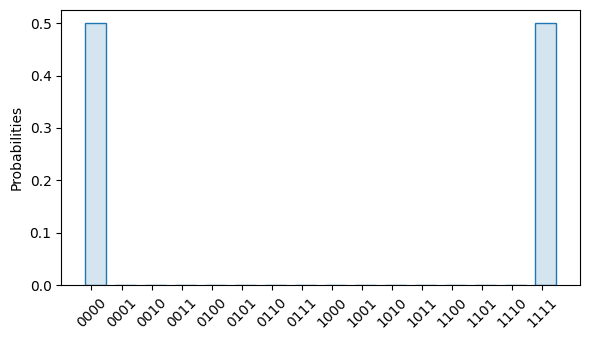

In [7]:
tq.Simulator().sample(ghz(4), n_shots=np.inf).plot()

In [8]:
circuit = compiler.compile(ghz(4))
circuit

Circuit(Cycle((0,): r90(theta), (1,): r90(theta)),Cycle((0,): r90(theta), (1,): r90(theta)),Cycle((0, 1): cz()),Cycle((1,): r90(theta), (2,): r90(theta)),Cycle((1,): r90(theta), (2,): r90(theta)),Cycle((1, 2): cz()),Cycle((2,): r90(theta), (3,): r90(theta)),Cycle((2,): r90(theta), (3,): r90(theta)),Cycle((2, 3): cz()),Cycle((0,): r90(theta), (1,): r90(theta), (2,): r90(theta), (3,): r90(theta)),Cycle((0,): r90(theta), (1,): r90(theta), (2,): r90(theta), (3,): r90(theta)),Cycle((0,): Meas(), (1,): Meas(), (2,): Meas(), (3,): Meas(), marker=1))

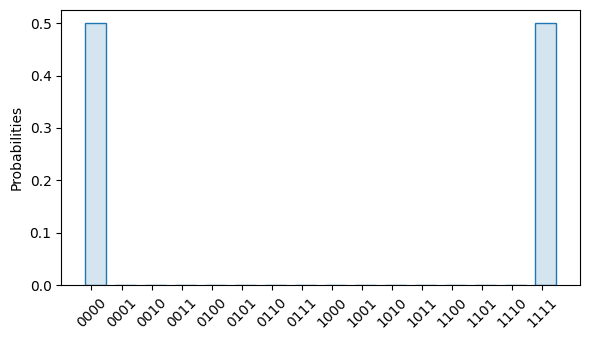

In [9]:
tq.Simulator().sample(circuit, n_shots=np.inf).plot()

In [10]:
# define parametric gate factories
r90 = tq.config.GateFactory.from_hamiltonian(
    "r90", [["Z", "-theta"], ["X", "90"], ["Z", "theta"]]
)
cr = tq.config.GateFactory.from_hamiltonian(
    "cr", [["IZ", "-theta"], ["ZX", "90"], ["IZ", "theta"]]
)

# factory for our virtual gate
z = tq.config.GateFactory.from_hamiltonian("z", [["Z", "theta"]])

# factory for static gates, equal to our parametric gates at 0
x90 = tq.config.GateFactory.from_matrix("x90", r90(0))
cr0 = tq.config.GateFactory.from_matrix("cr0", cr(0))

# put everything into a factory list. static gates should go first
factories = [x90, z, cr0, r90, cr]

In [11]:
compiler = tq.Compiler(
    [
        tq.compilation.Native2Q(factories),
        tq.compilation.Justify(),
        tq.compilation.Merge(),
        tq.compilation.RemoveId(),
        tq.compilation.Native1Q(factories),
        tq.compilation.PhaseTrack(factories),
        tq.compilation.Justify(),
    ]
)

circuit = compiler.compile(ghz(4))
circuit

Circuit(Cycle((0,): r90(theta), (1,): r90(theta)),Cycle((0,): r90(theta), (1,): r90(theta)),Cycle((0, 1): cr(theta)),Cycle((1,): r90(theta), (2,): r90(theta)),Cycle((1,): r90(theta), (2,): r90(theta)),Cycle((1, 2): cr(theta)),Cycle((2,): r90(theta), (3,): r90(theta)),Cycle((2,): r90(theta), (3,): r90(theta)),Cycle((2, 3): cr(theta)),Cycle((3,): r90(theta)),Cycle((3,): r90(theta)),Cycle((0,): Meas(), (1,): Meas(), (2,): Meas(), (3,): Meas(), marker=1))

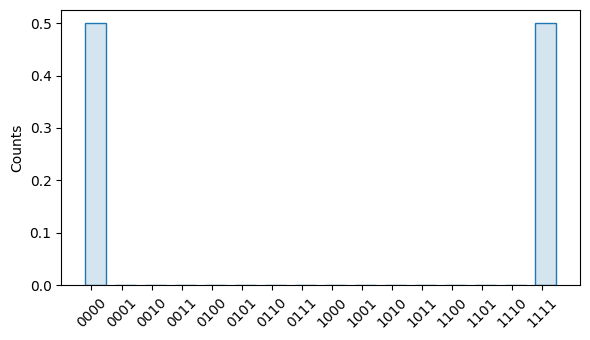

In [12]:
tq.Simulator().sample(circuit, n_shots=np.inf).plot()

In [13]:
# factories for our parametric gates. the first is a 90 degree rotation about an axis in
# the x-y plane, equivalent to z(a)*x(90)*z(-a). the second is a Mølmer-Sørensen gate
# with phase rotation a on the first qubit and b on the second qubit, i.e. equivalent to
# (z(a) & z(b))*xx(90)*(z(-a) & z(-b))
r90 = tq.config.GateFactory.from_hamiltonian(
    "r90", [["Z", "-theta"], ["X", "90"], ["Z", "theta"]]
)
ms = tq.config.GateFactory.from_hamiltonian(
    "ms", [["IZ", "-b"], ["ZI", "-a"], ["XX", 90], ["ZI", "a"], ["IZ", "b"]]
)

# factory for our virtual gate
z = tq.config.GateFactory.from_hamiltonian("z", [["Z", "theta"]])

# factory for static gates, equal to our parametric gates at 0
x90 = tq.config.GateFactory.from_matrix("x90", r90(0))
ms0 = tq.config.GateFactory.from_matrix("ms0", ms(0, 0))

# put everything into a factory list
factories = [x90, z, ms0, r90, ms]

phase_tracker = tq.compilation.PhaseTrack(factories)
phase_tracker._rules

{x90(): ({0: 'theta'},
  GateFactory(name='r90', layers=[Rotation.from_pauli('Z', 'theta', -1.0), FixedRotation.from_pauli('X', 90.0), Rotation.from_pauli('Z', 'theta', 1.0)], parameters={'theta': None})),
 ms0(): ({1: 'b', 0: 'a'},
  GateFactory(name='ms', layers=[Rotation.from_pauli('IZ', 'b', -1.0), Rotation.from_pauli('ZI', 'a', -1.0), FixedRotation.from_pauli('XX', 90.0), Rotation.from_pauli('ZI', 'a', 1.0), Rotation.from_pauli('IZ', 'b', 1.0)], parameters={'b': None, 'a': None}))}

In [14]:
compiler = tq.Compiler(
    [
        tq.compilation.Native2Q(factories),
        tq.compilation.Justify(),
        tq.compilation.Merge(),
        tq.compilation.RemoveId(),
        tq.compilation.Native1Q(factories),
        tq.compilation.PhaseTrack(factories),
        tq.compilation.Justify(),
    ]
)

circuit = compiler.compile(ghz(4))
circuit

Circuit(Cycle((0,): r90(theta)),Cycle((0,): r90(theta)),Cycle((0, 1): ms(b, a)),Cycle((1,): r90(theta)),Cycle((1,): r90(theta)),Cycle((1, 2): ms(b, a)),Cycle((2,): r90(theta)),Cycle((2,): r90(theta)),Cycle((2, 3): ms(b, a)),Cycle((0,): r90(theta), (1,): r90(theta), (2,): r90(theta), (3,): r90(theta)),Cycle((0,): r90(theta), (1,): r90(theta), (2,): r90(theta), (3,): r90(theta)),Cycle((0,): Meas(), (1,): Meas(), (2,): Meas(), (3,): Meas(), marker=1))

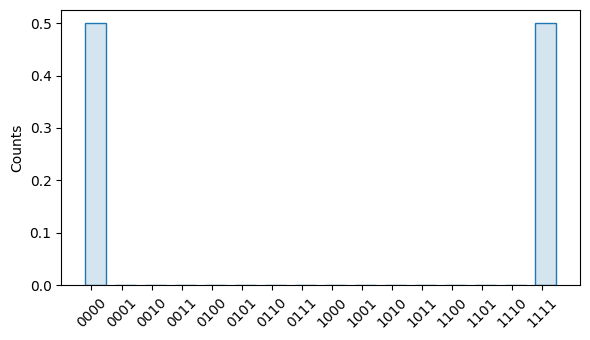

In [15]:
tq.Simulator().sample(circuit, n_shots=np.inf).plot()